### Seq 2 seq


In [2]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib.distributions import Bernoulli
from tensorflow.contrib.layers import fully_connected
def rnn_with_feed_prev(cell, inputs, initial_state, is_training):
    
    prev = None
    outputs = []
    sample_prob = 0 # config.sample_prob # scheduled sampling probability
    burn_in_steps =5
    use_error_prop = True
    feed_prev = not is_training if use_error_prop else False
    is_sample = is_training and sample_prob > 0 

    if feed_prev:
        print("Creating model --> Feeding output back into input.")
    else:
        print("Creating model input = ground truth each timestep.")

    with tf.variable_scope("rnn") as varscope:
        if varscope.caching_device is None:
            varscope.set_caching_device(lambda op: op.device)

        inputs_shape = inputs.get_shape().with_rank_at_least(3)
        batch_size = tf.shape(inputs)[0] 
        num_steps = inputs_shape[1]
        input_size = inputs_shape[2]
        burn_in_steps = burn_in_steps
        output_size = cell.output_size #hidden size

        # phased lstm input
        inp_t = tf.expand_dims(tf.range(1,batch_size+1), 1)

#         dist = Bernoulli(probs=sample_prob)
#         samples = dist.sample(sample_shape=num_steps)

#         initial_state = cell.zero_state(batch_size, dtype= tf.float32)
        state = initial_state

        for time_step in range(num_steps):

            if time_step > 0:
                tf.get_variable_scope().reuse_variables()

            inp = inputs[:, time_step, :]
            if is_sample and time_step > 0: 
                inp = tf.cond(tf.cast(samples[time_step], tf.bool), lambda:_hidden_to_output(prev, output_size, input_size), lambda:tf.identity(inp) )

            if feed_prev and prev is not None and time_step >= burn_in_steps:
                with tf.variable_scope(tf.get_variable_scope(), reuse=True):
                    inp = fully_connected(prev, int(input_size),  activation_fn=tf.sigmoid)
                    print("t", time_step, ">=", burn_in_steps, "--> feeding back output into input.")

            if isinstance(cell._cells[0], tf.contrib.rnn.PhasedLSTMCell):
                (cell_output, state) = cell((inp_t, inp), state)
            else:
                (cell_output, state) = cell(inp, state)


            prev = cell_output

            with tf.variable_scope(tf.get_variable_scope(), reuse=False):
                output = fully_connected(cell_output, int(input_size), activation_fn=tf.sigmoid)
                outputs.append(output)

    outputs = tf.stack(outputs, 1)

    return outputs, state

# %load train_seq2seq.py
"""Functions for downloading and reading time series data."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import random_seed

import tensorflow as tf
from tensorflow.contrib import rnn
from reader import read_data_sets
import numpy 

'''
To forecast time series using a recurrent neural network, we consider every 
row as a sequence of short time series. Because dataset times series has 9 dim, we will then
handle 9 sequences for every sample.
'''


# Training Parameters
learning_rate = 0.01
training_steps = 1000
inp_steps = 20
out_steps = 101-inp_steps
num_test_steps = inp_steps #EOS
batch_size = 20
display_step = 200

dataset, stats = read_data_sets("./lorenz.npy", inp_steps, num_test_steps)

# Network Parameters
num_input = stats['num_input']  # dataset data input (time series dimension: 3)
num_hidden = 16 # hidden layer num of features
num_layers = 2 # number of layers

# tf Graph input
X = tf.placeholder("float", [None, inp_steps, num_input])
Y = tf.placeholder("float", [None, out_steps, num_input])

# Decoder output
Z = tf.placeholder("float", [None, out_steps, num_input])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_input]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_input]))
}

def RNN(enc_inps, dec_inps,  weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, inp_steps, n_input)
    # Required shape: 'inp_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'inp_steps' tensors of shape (batch_size, n_input)
    enc_inps = tf.unstack(enc_inps, inp_steps, 1)
#     dec_inps = tf.unstack(dec_inps, out_steps, 1)


    # Define a lstm cell with tensorflow
    def lstm_cell():
        return tf.contrib.rnn.BasicLSTMCell(num_hidden,forget_bias=1.0)
    stacked_lstm = tf.contrib.rnn.MultiRNNCell(
        [lstm_cell() for _ in range(num_layers)])

    # Get lstm cell output --use as encoder
    enc_outs, enc_states = rnn.static_rnn(stacked_lstm, enc_inps, dtype=tf.float32)
    dec_outs, dec_states  = rnn_with_feed_prev(stacked_lstm, dec_inps, enc_states, False)

#     enc_outs, enc_states = rnn.static_rnn(stacked_lstm, enc_inps, dtype=tf.float32)
#     dec_outs, dec_states = rnn.static_rnn(stacked_lstm, dec_inps, initial_state = enc_states, dtype=tf.float32)
    
    # Concatenate all hidden states with linear
#     logits = []
#     for output in dec_outs:
#         logit = tf.matmul(output, weights['out']) + biases['out']
#         logits.append(logit) 
#     logits= tf.stack(logits, 1)
    logits = dec_outs
    return logits


prediction = RNN(X, Y, weights, biases)


# Define loss and optimizer
loss_op = tf.reduce_mean(tf.squared_difference(prediction, Z))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, Z:batch_z})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss 
            loss = sess.run(loss_op, feed_dict={X: batch_x,Y: batch_y, Z:batch_z})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) )

    print("Optimization Finished!")

    # Calculate accuracy for 128 dataset test inps
    test_len = 10
    test_enc_inps = dataset.test.enc_inps[:test_len].reshape((-1, inp_steps, num_input))
    test_dec_inps = dataset.test.dec_inps[:test_len].reshape((-1, out_steps, num_input))
    test_dec_outs = dataset.test.dec_outs[:test_len].reshape((-1, out_steps, num_input))

    
    # Fetch the predictions 
    fetches = {
        "true":Y,
        "pred":prediction,
        "loss":loss_op
    }
    vals = sess.run(fetches, feed_dict={X: test_enc_inps, Y: test_dec_inps, Z: test_dec_outs})
    print("Testing Loss:", vals["loss"])

loading time series ...
input type  <class 'numpy.ndarray'> (1000, 100, 3)
normalize to (0-1)
Creating model --> Feeding output back into input.
t 5 >= 5 --> feeding back output into input.
t 6 >= 5 --> feeding back output into input.
t 7 >= 5 --> feeding back output into input.
t 8 >= 5 --> feeding back output into input.
t 9 >= 5 --> feeding back output into input.
t 10 >= 5 --> feeding back output into input.
t 11 >= 5 --> feeding back output into input.
t 12 >= 5 --> feeding back output into input.
t 13 >= 5 --> feeding back output into input.
t 14 >= 5 --> feeding back output into input.
t 15 >= 5 --> feeding back output into input.
t 16 >= 5 --> feeding back output into input.
t 17 >= 5 --> feeding back output into input.
t 18 >= 5 --> feeding back output into input.
t 19 >= 5 --> feeding back output into input.
t 20 >= 5 --> feeding back output into input.
t 21 >= 5 --> feeding back output into input.
t 22 >= 5 --> feeding back output into input.
t 23 >= 5 --> feeding back outpu

In [3]:
numpy.save("./result/lstm_seq2seq_errprop.npy", (vals["true"], vals["pred"]))

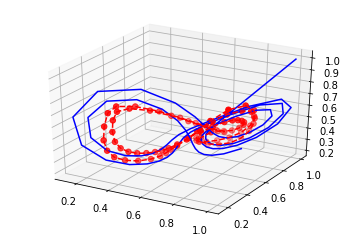

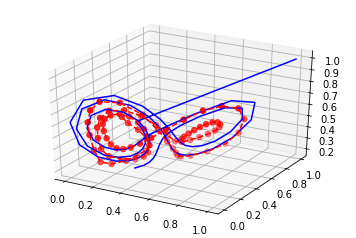

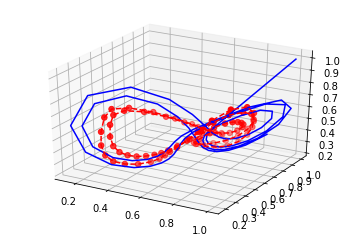

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')
test_vals = vals
pred = test_vals['pred']
true = test_vals['true']
plot_sample(pred, true,1)
plot_sample(pred, true,3)
plot_sample(pred, true,7)
# np.save('../experiments/result/trnn_10_err.npy',test_vals)

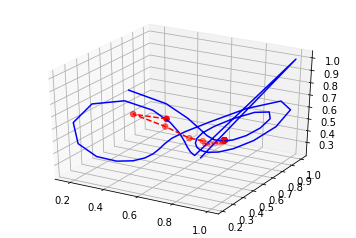

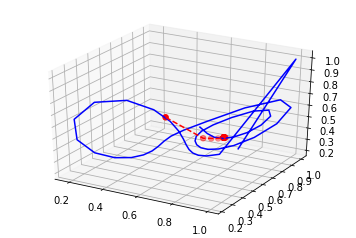

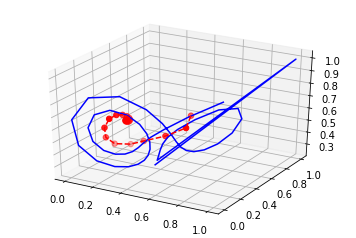

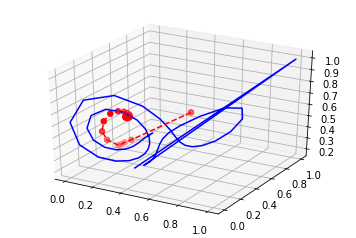

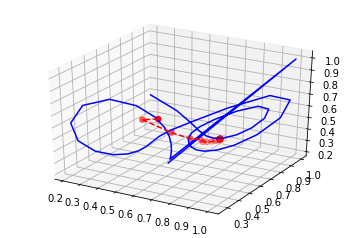

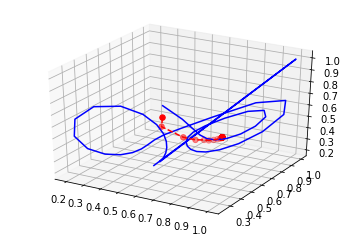

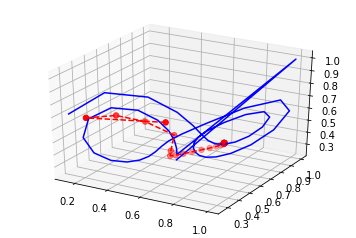

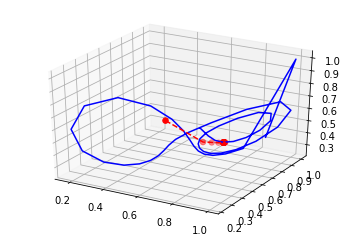

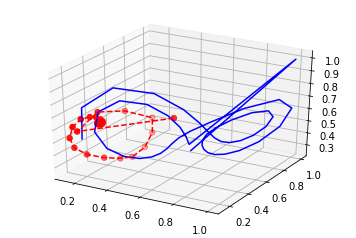

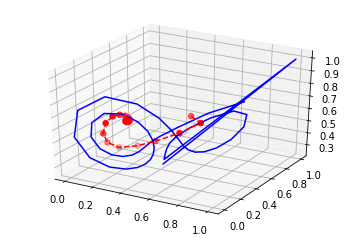

In [13]:
import numpy as np
true, pred = np.load('./result/trnn_seq2seq.npy')
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_sample(pred, true, sample_id):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(true[sample_id, :,0], true[sample_id,:,1], true[sample_id, :,2], 'b')
    ax.scatter(pred[sample_id,:,0], pred[sample_id, :,1], pred[sample_id, :,2], c='r', s=30)
    ax.plot(pred[sample_id, :,0], pred[sample_id,:,1], pred[sample_id, :,2], 'r--')
for i in range(10):
    plot_sample(pred, true,i)
# plot_sample(pred, true,3)
# plot_sample(pred, true,20)